In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

  0%|          | 0/48000 [00:00<?, ?it/s]

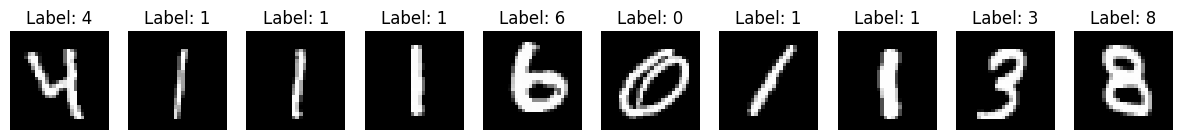

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [9]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])


train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [132]:
class VAESampler(nn.Module):
    def __init__(self, H_DIM, Z_DIM):
        super().__init__()
        self.mu = nn.Linear(H_DIM, Z_DIM)
        self.log_var = nn.Linear(H_DIM, Z_DIM)

    def forward(self, h):
        mu = self.mu(h)
        log_var = self.log_var(h)
        z = mu + torch.randn_like(mu) * torch.exp(0.5 * log_var)
        return z, mu, log_var, torch.tensor(0.0, device=z.device)
    
    def sample(self, num=1):
        raise NotImplementedError

class CompLookup2(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, dropout=0.2, beta=0.2, gamma=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_classes = num_classes
        self.beta = beta
        self.gamma = gamma

        self.keys = nn.Linear(input_dim, num_classes, bias=False)
        self.mu = nn.Parameter(torch.randn(num_classes, output_dim))
        self.log_var = nn.Parameter(torch.zeros(num_classes, output_dim))

        self.dropout = nn.Dropout(dropout)
        # Competition parameters
        self.register_buffer('total_fired', torch.ones(num_classes)*100.0)

    def get_gain(self, lim=10.0):
        firing_rate = self.total_fired / self.total_fired.sum()
        mean_firing_rate = firing_rate.mean()
        gain = mean_firing_rate / torch.clamp(firing_rate, min=mean_firing_rate/lim, max=mean_firing_rate*lim)
        return gain

    def forward(self, x):
        scores = self.keys(x) / (self.input_dim ** 0.5)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout(scores)

        if self.training:
            scores = scores * self.get_gain().unsqueeze(0)
            # self.keys.weight.data = F.normalize(self.keys.weight.data, p=2, dim=-1)
            sampled = torch.multinomial(scores, 1).squeeze()
            self.total_fired += torch.bincount(sampled, minlength=self.num_classes).float()
            commitment_loss = F.mse_loss(x, self.keys.weight[sampled].detach())
            codebook_loss = F.mse_loss(x.detach(), self.keys.weight[sampled])
            key_similarities = (self.keys.weight @ self.keys.weight.t()) / self.input_dim
            # key_loss = F.relu(key_similarities.triu(diagonal=1) - 0.00001).mean()
            key_loss = key_similarities.triu(diagonal=1).mean()
            q_loss = self.beta * commitment_loss + codebook_loss #+ self.gamma * key_loss
        else:
            sampled = scores.argmax(dim=-1)
            q_loss = torch.tensor(0.0, device=x.device)
        
        eps = torch.randn_like(self.mu)
        samples = self.mu + eps * torch.exp(0.5 * self.log_var)
        z = samples[sampled]
        mu, log_var = self.mu[sampled], self.log_var[sampled]

        z = z + scores @ samples.detach() - (scores @ samples).detach()

        # weighted_mu, weighted_log_var = scores @ self.mu, scores @ self.log_var
        # weighted_mu, weighted_log_var = scores @ self.mu.detach(), scores @ self.log_var.detach()
        # mu = mu + weighted_mu - weighted_mu.detach()
        # log_var = log_var + weighted_log_var - weighted_log_var.detach()
        # z = mu + eps * torch.exp(0.5 * log_var)

        return z, mu, log_var, q_loss
    
    def sample(self, num=1):
        idx = torch.randint(0, self.num_classes, (num,))
        mu, log_var = self.mu[idx], self.log_var[idx]
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * log_var)



class Lookup(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, dropout=0.0, beta=0.2, gamma=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_classes = num_classes
        self.beta = beta
        self.gamma = gamma

        self.keys = nn.Linear(input_dim, num_classes, bias=False)
        self.mu = nn.Parameter(torch.randn(num_classes, output_dim))
        self.log_var = nn.Parameter(torch.zeros(num_classes, output_dim))

        self.dropout = nn.Dropout(dropout)
        # Competition parameters
        self.register_buffer('total_fired', torch.ones(num_classes)*100.0)

    def forward(self, x):
        scores = self.keys(x) / (self.input_dim ** 0.5)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout(scores)

        if self.training:
            # self.keys.weight.data = F.normalize(self.keys.weight.data, p=2, dim=-1)
            sampled = torch.multinomial(scores, 1).squeeze()
            self.total_fired += torch.bincount(sampled, minlength=self.num_classes).float()
            commitment_loss = F.mse_loss(x, self.keys.weight[sampled].detach())
            codebook_loss = F.mse_loss(x.detach(), self.keys.weight[sampled])
            key_similarities = (self.keys.weight @ self.keys.weight.t()) / self.input_dim
            # key_loss = F.relu(key_similarities.triu(diagonal=1) - 0.00001).mean()
            key_loss = key_similarities.triu(diagonal=1).mean()
            q_loss = self.beta * commitment_loss + codebook_loss #+ self.gamma * key_loss
        else:
            sampled = scores.argmax(dim=-1)
            q_loss = torch.tensor(0.0, device=x.device)
        
        eps = torch.randn_like(self.mu)
        samples = self.mu + eps * torch.exp(0.5 * self.log_var)
        z = samples[sampled]
        mu, log_var = self.mu[sampled], self.log_var[sampled]

        z = z + scores @ samples.detach() - (scores @ samples).detach()

        # weighted_mu, weighted_log_var = scores @ self.mu, scores @ self.log_var
        # weighted_mu, weighted_log_var = scores @ self.mu.detach(), scores @ self.log_var.detach()
        # mu = mu + weighted_mu - weighted_mu.detach()
        # log_var = log_var + weighted_log_var - weighted_log_var.detach()
        # z = mu + eps * torch.exp(0.5 * log_var)

        return z, mu, log_var, q_loss
    
    def sample(self, num=1):
        idx = torch.randint(0, self.num_classes, (num,))
        mu, log_var = self.mu[idx], self.log_var[idx]
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * log_var)


class SimpleLookup(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, dropout=0.0, beta=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_classes = num_classes
        self.beta = beta

        self.keys = nn.Linear(input_dim, num_classes, bias=False)
        self.values = nn.Parameter(torch.randn(num_classes, output_dim))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        scores = self.keys(x) / (self.input_dim ** 0.5)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout(scores)

        if self.training:
            sampled = torch.multinomial(scores, 1).squeeze()
            commitment_loss = self.beta * F.mse_loss(x, self.keys.weight[sampled].detach())
            codebook_loss = F.mse_loss(x.detach(), self.keys.weight[sampled])
            q_loss = commitment_loss + codebook_loss
        else:
            sampled = scores.argmax(dim=-1)
            q_loss = torch.tensor(0.0, device=x.device)

        # mu, log_var = self.mu[sampled], self.log_var[sampled]
        # # weighted_mu, weighted_log_var = scores @ self.mu, scores @ self.log_var
        # weighted_mu, weighted_log_var = scores @ self.mu.detach(), scores @ self.log_var.detach()
        # mu = mu + weighted_mu - weighted_mu.detach()
        # log_var = log_var + weighted_log_var - weighted_log_var.detach()

        samples = self.values[sampled]
        weighted_samples = scores @ self.values.detach()
        samples = samples + weighted_samples - weighted_samples.detach()
        mu, log_var = torch.zeros_like(samples), torch.zeros_like(samples)



        return samples, mu, log_var, q_loss

    def sample(self, num=1):
        idx = torch.randint(0, self.num_classes, (num,))
        z = self.values[idx]
        return z


class CompLookup(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, dropout=0.0, beta=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_classes = num_classes
        self.beta = beta

        self.keys = nn.Linear(input_dim, num_classes, bias=False)
        self.mu = nn.Parameter(torch.randn(num_classes, output_dim))
        self.log_var = nn.Parameter(torch.zeros(num_classes, output_dim))

        self.dropout = nn.Dropout(dropout)

        # Competition parameters
        self.register_buffer('total_fired', torch.ones(num_classes)*100.0)
    
    def get_gain(self):
        firing_rate = self.total_fired / self.total_fired.sum()
        mean_firing_rate = firing_rate.mean()
        gain = mean_firing_rate / torch.clamp(firing_rate, min=mean_firing_rate/2, max=mean_firing_rate*2)
        return gain
    
    def forward(self, x):
        gain = self.get_gain() if self.training else torch.ones(self.num_classes, device=x.device)
        scores = self.keys(x) / (self.input_dim ** 0.5)
        scores = scores * gain.unsqueeze(0)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout(scores)

        if self.training:
            sampled = torch.multinomial(scores, 1).squeeze()
            self.total_fired += torch.bincount(sampled, minlength=self.num_classes).float()
        else:
            sampled = scores.argmax(dim=-1)
        commitment_loss = self.beta * F.mse_loss(x, self.keys.weight[sampled].detach())
        codebook_loss = F.mse_loss(x.detach(), self.keys.weight[sampled])
        q_loss = commitment_loss + codebook_loss

        mu, log_var = self.mu[sampled], self.log_var[sampled]
        weighted_mu, weighted_log_var = scores @ self.mu, scores @ self.log_var
        mu = mu + weighted_mu - weighted_mu.detach()
        log_var = log_var + weighted_log_var - weighted_log_var.detach()

        eps = torch.randn_like(mu)
        z = mu + eps * torch.exp(0.5 * log_var)
        return z, mu, log_var, q_loss

    def sample(self, num=1):
        idx = torch.randint(0, self.num_classes, (num,))
        mu, log_var = self.mu[idx], self.log_var[idx]
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * log_var)


batch_size = 32
input_dim = 128
output_dim = 16
num_classes = 64
dropout = 0.1
    
sampler = Lookup(input_dim, output_dim, num_classes, dropout=dropout).to(device)
x = torch.randn(batch_size, input_dim).to(device)
z, mu, log_var, q_loss = sampler(x)
print(z.shape, mu.shape, log_var.shape, q_loss.shape)

sampler = CompLookup(input_dim, output_dim, num_classes, dropout=dropout).to(device)
x = torch.randn(batch_size, input_dim).to(device)
z, mu, log_var, q_loss = sampler(x)
print(z.shape, mu.shape, log_var.shape, q_loss.shape)

torch.Size([32, 16]) torch.Size([32, 16]) torch.Size([32, 16]) torch.Size([])
torch.Size([32, 16]) torch.Size([32, 16]) torch.Size([32, 16]) torch.Size([])


In [158]:
Z_DIM = 128
H_DIM = 256
NUM_CLASSES = 1024
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('cpu')

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, H_DIM, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # self.var_sampler = CompLookup(H_DIM, Z_DIM, NUM_CLASSES, dropout=0.1)
        self.var_sampler = CompLookup2(H_DIM, Z_DIM, NUM_CLASSES, dropout=0.2)
        # self.var_sampler = Lookup(H_DIM, Z_DIM, NUM_CLASSES, dropout=0.1, beta=0.2, gamma=10.0)
        # self.var_sampler = SimpleLookup(H_DIM, Z_DIM, NUM_CLASSES, dropout=0.1)
        # self.var_sampler = VAESampler(H_DIM, Z_DIM)
        self.z2hid = nn.Linear(Z_DIM, H_DIM)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (H_DIM, 1, 1)),

            nn.ConvTranspose2d(H_DIM, 512, 3, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 1, 3, 1, 1),
        )

    def to(self, device):
        self.device = device
        return super().to(device)
    
    def encode(self, x):
        encoded = self.encoder(x)
        return self.var_sampler(encoded)
        
    def decode(self, z):
        hid = self.z2hid(z)
        return self.decoder(hid)

    def forward(self, x):
        z, mu, log_var, q_loss = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, q_loss
    
    def sample(self, num_samples, device):
        with torch.no_grad():
            z = self.var_sampler.sample(num_samples).to(device)
            h = self.z2hid(z)
            samples = self.decoder(h)
            return samples

In [159]:
def loss_fn(recon_x, x, mu, log_var, q_loss, vae_beta=1.0, q_beta=0.2):
    recon_loss = F.binary_cross_entropy_with_logits(recon_x, x, reduction="sum")
    mse = F.mse_loss(F.sigmoid(recon_x), x)
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    vae_loss = (recon_loss + vae_beta*kld) / x.size(0)
    loss = vae_loss + q_beta*q_loss
    return loss, mse

def train(
        model,
        train_set,
        val_set,
        optimizer,
        n_epochs,
        batch_size,
        vae_beta=1.0,
        q_beta=0.2,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_mses = []
    train_q_losses = []
    val_losses = []
    val_mses = []
    val_q_losses = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(n_epochs):
        train_set.apply_transform()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        train_mse = 0 
        train_q_loss = 0
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], train_mse=train_mses[-1], val_mse=val_mses[-1])

            with torch.cuda.amp.autocast():
                decoded, mu, log_var, q_loss = model(x)
                loss, mse = loss_fn(decoded, x, mu, log_var, q_loss, vae_beta, q_beta)

            train_loss += loss.item()
            train_mse += mse.item()
            train_q_loss += q_loss.item()
            
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        train_losses.append(train_loss / len(train_set))
        train_mses.append(train_mse / len(train_set))
        train_q_losses.append(train_q_loss / len(train_set))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mse = 0
            val_q_loss = 0
            for x, _ in val_loader:
                with torch.cuda.amp.autocast():
                    decoded, mu, log_var, q_loss = model(x)
                    loss, mse = loss_fn(decoded, x, mu, log_var, q_loss, vae_beta, q_beta)
                val_loss += loss.item()
                val_mse += mse.item()
                val_q_loss += q_loss.item()

            val_losses.append(val_loss / len(val_set))
            val_mses.append(val_mse / len(val_set))
            val_q_losses.append(val_q_loss / len(val_set))
        
    return train_losses, val_losses, train_mses, val_mses, train_q_losses, val_q_losses

In [160]:
model = VAE().to(device)
LR = 1e-4
WD = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
EPOCHS = 1000
BATCH_SIZE = 32
VAE_BETA = 0.2
Q_BETA = 0.1

train_losses, val_losses, train_mses, val_mses, train_q_losses, val_q_losses = train(model, train_set, val_set, optimizer, EPOCHS, BATCH_SIZE, VAE_BETA, Q_BETA)

median firing rate: 0.0009302134858444333


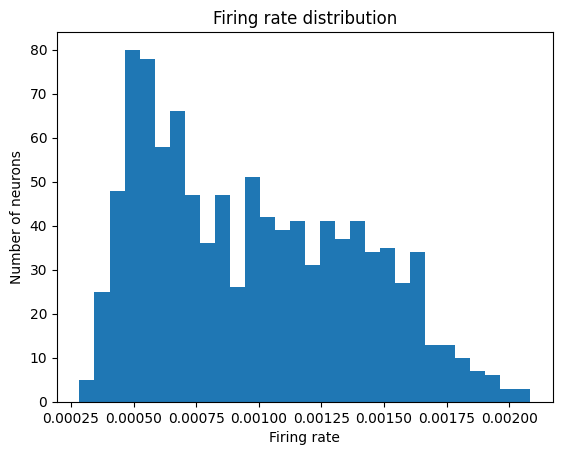

In [161]:
firing_rates = (model.var_sampler.total_fired / model.var_sampler.total_fired.sum()).cpu().numpy()
print(f'median firing rate: {np.median(firing_rates)}')

# plot histogram
plt.hist(firing_rates, bins=30)
plt.xlabel('Firing rate')
plt.ylabel('Number of neurons')
plt.title('Firing rate distribution')
plt.show()

Min MSE: 0.0013369660722091794


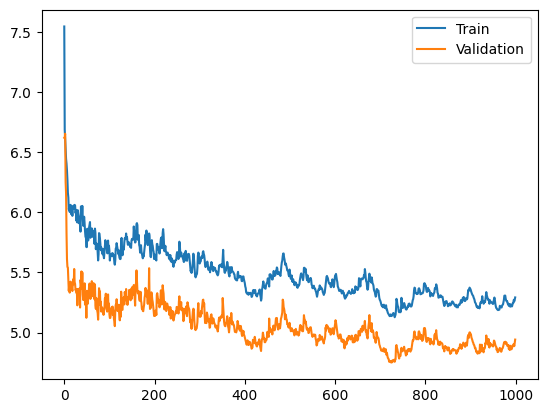

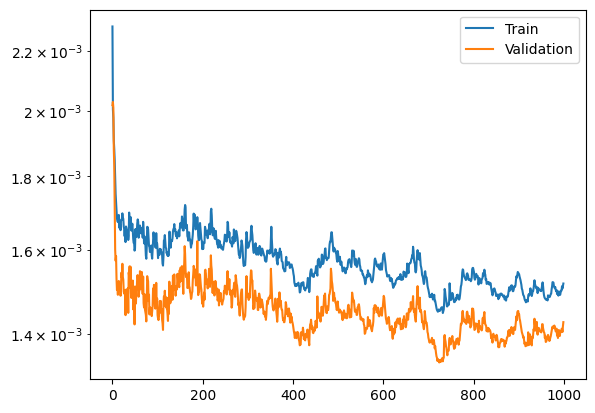

In [162]:
print('Min MSE:', min(val_mses))
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()
# Plot mses
plt.plot(train_mses, label='Train')
plt.plot(val_mses, label='Validation')
plt.yscale('log')
plt.legend()
plt.show()

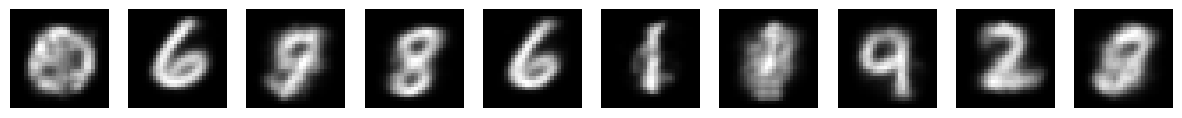

In [163]:
images = model.sample(10, device)
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze().sigmoid().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

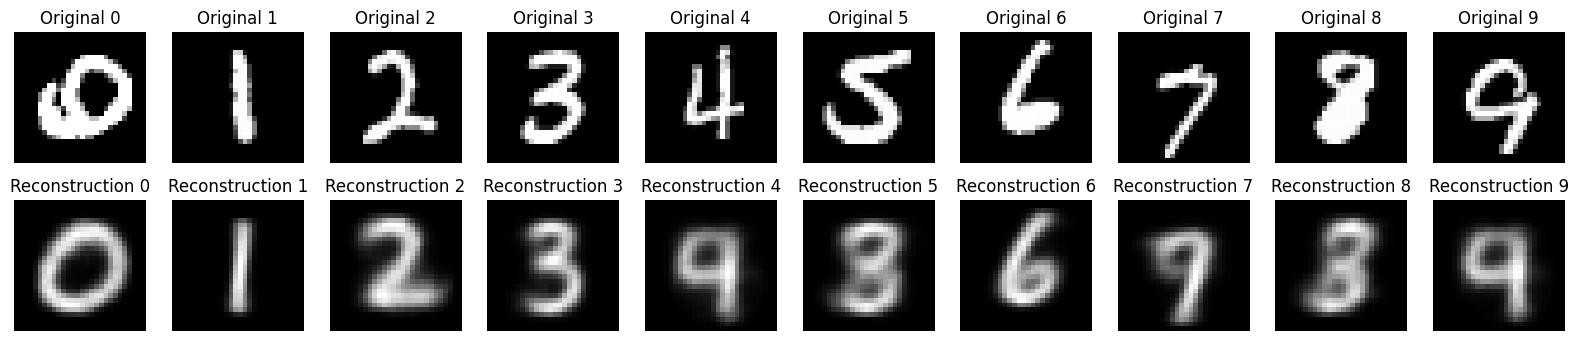

In [164]:
# Collect 1 image per class
model.eval()
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = x_hat.sigmoid().squeeze(0)

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [41]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(20, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            mu, _ = model.encode(x)
            pred = classifier(mu.detach())
            loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            mu, _ = model.encode(x)
            pred = classifier(mu.detach())
            loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [42]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, BATCH_SIZE)

KeyboardInterrupt: 